# MNIST
## MNIST (Modified National Institute of Standards and Technology)
## Содержит 70 тысяч образцов рукописного написания цифр размером 28х28 пикселей

In [ ]:
import numpy as np
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from IPython.display import clear_output
from matplotlib import pyplot as plt
from PIL import Image
import io
import base64
from google.colab import output


### Загружаем и сохраняем датасет [MNIST](https://docs.pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST)

In [ ]:
train_data = MNIST('.', train = True, transform = torchvision.transforms.ToTensor(), download = True)
test_data = MNIST('.', train = False, transform = torchvision.transforms.ToTensor(), download = True)

#### Используем стандартный загрузчик данных

In [ ]:
BATCH_SIZE = 64

train_data_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size = BATCH_SIZE,
    shuffle = True
    )

test_data_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size = BATCH_SIZE,
    shuffle = False
    )

print(f'Train dataset size: {len(train_data)}\nTest dataset size: {len(test_data)}')

### Визуализация сэмплов из датасета

In [ ]:
random_batch = next(iter(train_data_loader))
_image, _label = random_batch[0][0], random_batch[1][0]

plt.figure()
plt.imshow(_image.reshape(28, 28))
plt.title(f'Image label: {_label}')

### Создаем НС с помощью контейнера

In [ ]:
# Смотрим доки
# print(nn.Module.__doc__)

# Create model instance
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2,stride=2),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(in_features=64 * 7 * 7, out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=10)
    )

print('Weight shapes:', [w.shape for w in model.parameters()])

### Повторим оригинальную архитектуру LeNet5
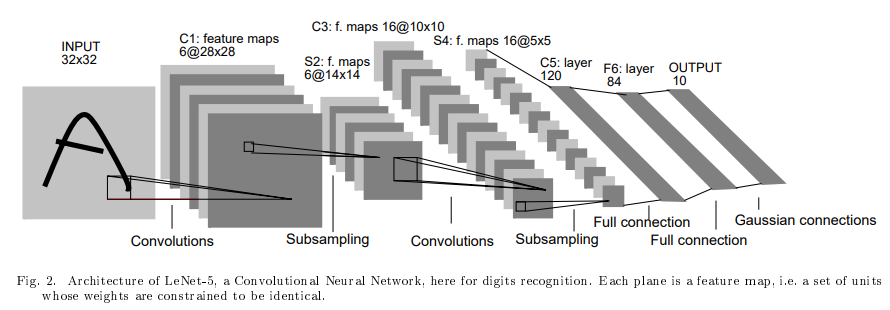

In [ ]:
model_LeNet5 = nn.Sequential(
    # padding до 32x32
    nn.ZeroPad2d(padding=(2, 2, 2, 2)),  # (left, right, top, bottom)

    # C1: 6 фильтров с ядром свертки 5х5
    nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=0),
    nn.Tanh(),

    # S2: average pooling 2х2 с шагом 2
    nn.AvgPool2d(kernel_size=2, stride=2),

    # C3: 16 фильтров с ядром свертки 5х5
    nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0),
    nn.Tanh(),

    # S4: average pooling 2х2 с шагом 2
    nn.AvgPool2d(kernel_size=2, stride=2),

    # C5: свёртка 5x5, 120 фильтров (работает как полносвязный слой над 5x5)
    nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1, padding=0),
    nn.Tanh(),

    # "вытягиваем" в вектор
    nn.Flatten(),

    # F6: полносвязный линейный слой
    nn.Linear(in_features=120, out_features=84),
    nn.Tanh(),

    # выходной слой на 10 классов
    nn.Linear(in_features=84, out_features=10)
)

print('Weight shapes:', [w.shape for w in model_LeNet5.parameters()])

### Задаем параметры обучения

In [ ]:
NUM_EPOCHS = 20
LR = 0.1
history = []
plot_history = []
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = LR)
# optimizer = torch.optim.Adam(model.parameters(), lr = LR)
iter_num = round((len(train_data) / BATCH_SIZE) * NUM_EPOCHS)
print(f'Total iterations: {iter_num}')

### Цикл обучения

In [ ]:
for epoch in range(NUM_EPOCHS):
    model.train()

    for _i, batch in enumerate(train_data_loader):
        x, y = batch
        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_function(y_pred, y)
        loss.backward()
        optimizer.step()

        history.append(loss.item())

        if (_i + 1) % 100 == 0:
            clear_output(True)
            plt.figure(figsize=(15,10))
            plot_history.append(np.mean(history[-100:]))
            plt.plot(plot_history, label='Loss')
            plt.yscale('log')
            plt.grid()
            plt.xlabel('Iteration * 100')
            plt.ylabel('Loss')
            plt.legend()
            plt.show()

In [ ]:
# оценка качества модели на тестовом наборе
predicted_labels = []
real_labels = []

# переходим в режим eval
model.eval()

# не считаем градиенты
with torch.no_grad():
  for batch in test_data_loader:
    y_predicted = model(batch[0])
    predicted_labels.append(y_predicted.argmax(dim=1))
    real_labels.append(batch[1])

predicted_labels = torch.cat(predicted_labels)
real_labels = torch.cat(real_labels)
test_accuracy = (predicted_labels == real_labels).type(torch.FloatTensor).mean()
print(f'Accuracy on test set: {test_accuracy:3.5}')

# оценка качества модели на тренировочном наборе
predicted_labels = []
real_labels = []

# переходим в режим eval
model.eval()

# не считаем градиенты
with torch.no_grad():
  for batch in train_data_loader:
    y_predicted = model(batch[0])
    predicted_labels.append(y_predicted.argmax(dim=1))
    real_labels.append(batch[1])

predicted_labels = torch.cat(predicted_labels)
real_labels = torch.cat(real_labels)
train_accuracy = (predicted_labels == real_labels).type(torch.FloatTensor).mean()
print(f'Accuracy on train set: {train_accuracy:3.5}')

### Интерактивное тестирование модели
#### (вайб-кодинг by Gemini AI)

In [ ]:
from IPython.display import HTML, display, clear_output
from ipywidgets import VBox, Button, Output
import io
import base64
from google.colab import output
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import torch
import torch.nn.functional as F


# The canvas setup and widgets are already defined in previous steps.
# Re-defining them here to ensure the context is complete for this cell, though in a notebook
# they would typically be defined once.
canvas_width = 280
canvas_height = 280

handle_predict_js_func = """
    async function predictDigit() {
        const canvas = document.getElementById('drawing_canvas');
        if (!canvas) {
            console.error("Canvas element not found!");
            return;
        }
        const dataURL = canvas.toDataURL('image/png');
        try {
            await google.colab.kernel.invokeFunction('predict_image', [dataURL]);
        } catch (e) {
            console.error("Error invoking Python function", e);
        }
    }
"""

canvas_html = f"""
<canvas id="drawing_canvas" width="{canvas_width}" height="{canvas_height}" style="border:2px solid #000;"></canvas>
<script type="text/javascript">
    var canvas = document.getElementById('drawing_canvas');
    var ctx = canvas.getContext('2d');
    var drawing = false;

    ctx.lineWidth = 10; // Decreased line width for finer drawing
    ctx.lineCap = 'round';
    ctx.strokeStyle = 'black';

    // Initialize canvas with white background
    ctx.fillStyle = 'white';
    ctx.fillRect(0, 0, canvas.width, canvas.height);

    canvas.addEventListener('mousedown', function(e) {{
        drawing = true;
        ctx.beginPath();
        ctx.moveTo(e.offsetX, e.offsetY);
    }});

    canvas.addEventListener('mousemove', function(e) {{
        if (drawing) {{
            ctx.lineTo(e.offsetX, e.offsetY);
            ctx.stroke();
        }}
    }});

    canvas.addEventListener('mouseup', function() {{
        drawing = false;
    }});

    canvas.addEventListener('mouseout', function() {{
        drawing = false;
    }});

    function clearCanvas() {{
        ctx.clearRect(0, 0, canvas.width, canvas.height); // Clears to transparent black
        ctx.fillStyle = 'white'; // Set fill style to white
        ctx.fillRect(0, 0, canvas.width, canvas.height); // Fill with white
    }}

</script>
<button onclick="predictDigit()">Predict</button>
<button onclick="clearCanvas()">Clear</button>
<script>{handle_predict_js_func}</script>
"""

# Create an Output widget to hold the HTML canvas
canvas_output = Output()
with canvas_output:
    display(HTML(canvas_html))

predict_output = Output()
clear_output_button = Button(description="Clear Python Output")

def on_clear_output_button_clicked(b):
    with predict_output:
        clear_output(wait=True)

clear_output_button.on_click(on_clear_output_button_clicked)

# Register the Python function that will handle the data from JavaScript
def predict_image(dataURL):
    # Clear previous output at the very beginning of the function execution
    with predict_output:
        clear_output(wait=True)

    # Decode the base64 dataURL
    encoded_data = dataURL.split(',')[1]
    decoded_data = base64.b64decode(encoded_data)

    # Open the image using PIL
    image = Image.open(io.BytesIO(decoded_data))

    # Convert to grayscale, resize, and convert to NumPy array
    image = image.convert('L') # Convert to grayscale
    image = image.resize((28, 28)) # Resize to 28x28
    image_np = np.array(image) # Convert to NumPy array

    # Invert colors (canvas is black on white, MNIST is white on black)
    image_np = 255 - image_np

    # Normalize pixel values to [0, 1]
    image_np = image_np / 255.0

    # Convert to PyTorch tensor and reshape to (1, 1, 28, 28)
    image_tensor = torch.from_numpy(image_np).float()
    image_tensor = image_tensor.unsqueeze(0).unsqueeze(0) # Add batch and channel dimension

    # Prediction logic
    model.eval() # Set model to evaluation mode
    with torch.no_grad(): # Disable gradient calculation
        outputs = model(image_tensor)
        probabilities = F.softmax(outputs, dim=1)
        predicted_digit = torch.argmax(probabilities, dim=1).item()

    with predict_output:
        # Display preprocessed image
        plt.figure(figsize=(2,2))
        plt.imshow(image_np, cmap='gray')
        plt.title('Preprocessed Input Image')
        plt.axis('off')
        display(plt.gcf())
        plt.close()

        # Display predicted digit and probabilities
        print(f"Predicted Digit: {predicted_digit}")
        print("Probabilities per class:")
        for i, prob in enumerate(probabilities.squeeze().numpy()):
            print(f"  Digit {i}: {prob:.4f}")

        # Create bar chart
        fig, ax = plt.subplots(figsize=(8, 4))
        digits = np.arange(10)
        ax.bar(digits, probabilities.squeeze().numpy(), color='skyblue')

        # Highlight predicted digit
        ax.bar(predicted_digit, probabilities.squeeze()[predicted_digit].item(), color='red')

        ax.set_xticks(digits)
        ax.set_xlabel('Digit')
        ax.set_ylabel('Probability')
        ax.set_title('Predicted Digit Probabilities')
        ax.grid(axis='y', linestyle='--', alpha=0.7)

        # Display the plot
        display(fig)
        plt.close(fig) # Close the figure to prevent it from being displayed twice
output.register_callback('predict_image', predict_image)

### Рисуем цифру и получаем прогноз модели

In [ ]:
display(VBox([canvas_output, clear_output_button, predict_output]))